In [1]:
# -*- coding: utf-8 -*-
#
# Author: Milan Ondrasovic <milan.ondrasovic@gmail.com>
#
# MIT License
#
# Copyright (c) 2021 Milan Ondrašovič
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import config

from stat_plot import plot_improvement_over_baseline_boxes, plot_error_vals_hist

plt.style.use('tableau-colorblind10')
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 8

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [23]:
with open(config.RESULTS_FILE_PATH, 'rb') as in_file:
    experiment_spec_df, single_homography_df, homography_order_df =\
        pickle.load(in_file)

df = experiment_spec_df.merge(
    single_homography_df, on='inst_id'
).merge(homography_order_df, on='inst_id').sort_values(
    ['scenar_id', 'inst_id', 'group_idx']
)
print(df.shape)
df.head(3)

(78000, 16)


,scenar_id,inst_id,shape,n_groups,transl,rot,scale,noise,time_elapsed_ns,group_idx,min,max,mean,med,std,order
22169,1,4335,rectangle,6,False,False,False,False,0,0,0.00000,0.00062,0.00018,0.00011,0.00017,"(1, 0, 4, 2, 5, 3)"
22170,1,4335,rectangle,6,False,False,False,False,0,1,0.00000,0.00062,0.00012,0.00008,0.00012,"(1, 0, 4, 2, 5, 3)"
22171,1,4335,rectangle,6,False,False,False,False,0,2,0.00000,0.00182,0.00041,0.00032,0.00036,"(1, 0, 4, 2, 5, 3)"


In [24]:
def calc_improvements_over_baseline(scenar_df, stats_col='mean'):
    n_groups = scenar_df['n_groups'].values[0]

    error_vals = scenar_df[stats_col].values.reshape(-1, n_groups)
    baselines = error_vals.mean(axis=1)[..., None]
    groups_orders = np.asarray(
        [*scenar_df.groupby('inst_id').head(1)['order'].values]
    )
    row_idx = np.arange(0, len(error_vals))
    error_vals_ordered = error_vals[row_idx[..., None], groups_orders]
    absolute_improvements = baselines - error_vals_ordered
    relative_improvements = absolute_improvements / baselines

    return absolute_improvements, relative_improvements

def build_scenario_label(scenar_df_row):
    assert len(scenar_df_row) == 1

    affine_parts = []
    if scenar_df_row['rot'].bool():
        affine_parts.append('rotation')
    if scenar_df_row['transl'].bool():
        affine_parts.append('translation')
    if scenar_df_row['scale'].bool():
        affine_parts.append('scale')

    label = ', '.join(affine_parts) if affine_parts else 'no affine'
    if scenar_df_row['noise'].bool():
        label += f' + noise'

    used_shape = scenar_df_row['shape'].values[0]
    if used_shape == 'rectangle':  # A dirty hack!
        used_shape = 'square'
    label += f' | {used_shape}'

    return label

In [25]:
scenar_g = df.groupby('scenar_id')
scenar_g.head(1).iloc[:, [0] + list(range(2, 8))]

,scenar_id,shape,n_groups,transl,rot,scale,noise
22169,1,rectangle,6,False,False,False,False
28169,2,rectangle,6,True,False,False,False
34169,3,rectangle,6,False,True,False,False
40169,4,rectangle,6,False,False,True,False
9167,5,rectangle,6,True,True,True,False
13163,6,rectangle,6,True,True,True,True
19163,7,5-polygon,6,True,True,True,True
51167,8,7-polygon,6,True,True,True,True
0,9,9-polygon,6,True,True,True,True
1992,10,rectangle,3,True,True,True,True


In [26]:
# These groups should be checked manually (for now) in the given table whether
# the chosen scenarios that should be evaluated together correspond to the
# correct ones.

scenario_ids_groups = (
    (1, 2, 3, 4), # Change in affine transformations only.
    (5, 6), # Change in noise only (all affine transformations included).
    (6, 7, 8, 9), # Change in shape only (all affine transformations + noise)
    (10,),
    (11,),
    (12,),
    (13,),
)

********************************************************************************
RELATIVE IMPROVEMENTS
NO AFFINE | SQUARE --- TRANSLATION | SQUARE --- ROTATION | SQUARE --- SCALE | SQUARE, MARKERS NO.: 6
	median: 64.77%, 62.10%, 66.38%, 65.35%
	mean: 60.62%, 58.81%, 63.47%, 59.31%
	stdev: 20.09%, 20.81%, 18.32%, 23.24%
ABSOLUTE IMPROVEMENTS
NO AFFINE | SQUARE --- TRANSLATION | SQUARE --- ROTATION | SQUARE --- SCALE | SQUARE, MARKERS NO.: 6
	median: 0.00029, 0.00029, 0.00042, 0.00025
	mean: 0.00030, 0.00030, 0.00043, 0.00026
	stdev: 0.00014, 0.00014, 0.00019, 0.00014
********************************************************************************
RELATIVE IMPROVEMENTS
ROTATION, TRANSLATION, SCALE | SQUARE --- ROTATION, TRANSLATION, SCALE + NOISE | SQUARE, MARKERS NO.: 6
	median: 67.69%, 63.76%
	mean: 63.57%, 59.25%
	stdev: 20.99%, 21.97%
ABSOLUTE IMPROVEMENTS
ROTATION, TRANSLATION, SCALE | SQUARE --- ROTATION, TRANSLATION, SCALE + NOISE | SQUARE, MARKERS NO.: 6
	median: 0.00034, 22.5176

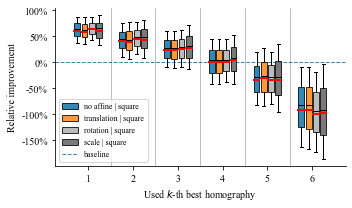

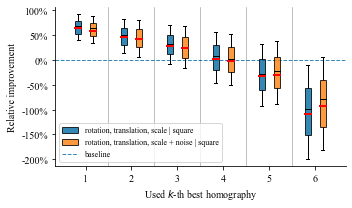

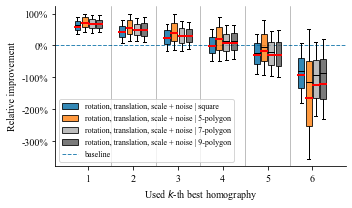

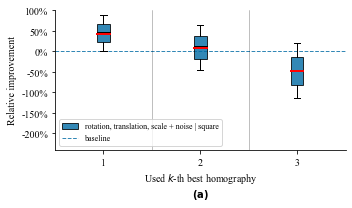

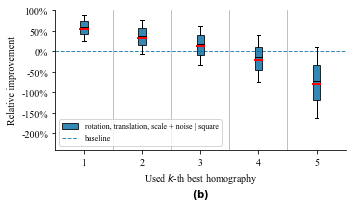

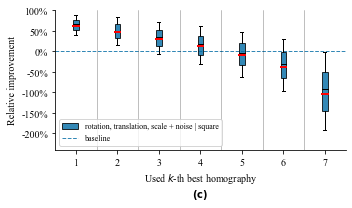

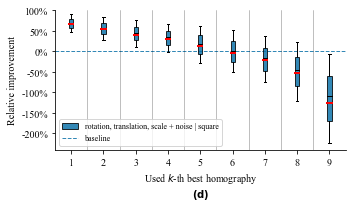

In [27]:
def create_subfig_id_label(text):
    return "\n" + rf"$\bf{{({text})}}$"

# Subfigure suffixes for each scenario group.
x_label_suffixes = (
    "",
    "",
    "",
    create_subfig_id_label("a"),
    create_subfig_id_label("b"),
    create_subfig_id_label("c"),
    create_subfig_id_label("d")
)

# x_label_suffixes = tuple(["" for _ in range(len(scenario_ids_groups))])

ax_y_lim = [-2.4, 1]
ax_y_limits = (
    None,
    None,
    None,
    ax_y_lim,
    ax_y_lim,
    ax_y_lim,
    ax_y_lim
)
ax_y_limits = tuple(ax_y_limits * len(scenario_ids_groups))

def print_abs_vals(vals):
    return ", ".join(map(lambda x: f"{x:.5f}", vals))

def print_rel_vals(vals):
    return ", ".join(map(lambda x: f"{x:.2%}", vals))

assert len(scenario_ids_groups) == len(x_label_suffixes)

for scenario_ids_group, x_label_suffix, ax_y_lim in zip(
        scenario_ids_groups, x_label_suffixes, ax_y_limits
):
    abs_improvements = []
    rel_improvements = []
    labels = []

    for scenar_id in scenario_ids_group:
        scenar_df = scenar_g.get_group(scenar_id)
        abs_improvement, rel_improvement = calc_improvements_over_baseline(
            scenar_df
        )
        abs_improvements.append(abs_improvement)
        rel_improvements.append(rel_improvement)
        labels.append(build_scenario_label(scenar_df[:1]))

    def print_improvement_stats(improvements, val_printer):
        tmp = np.asarray(improvements)
        print(f"{' --- '.join(labels)}, markers no.: {tmp.shape[-1]}".upper())
        print(f"\tmedian: {val_printer(np.median(tmp, axis=1)[:, 0])}")
        print(f"\tmean: {val_printer(np.mean(tmp, axis=1)[:, 0])}")
        print(f"\tstdev: {val_printer(np.std(tmp, axis=1)[:, 0])}")

    print("*" * 80)
    print("RELATIVE IMPROVEMENTS")
    print_improvement_stats(rel_improvements, print_rel_vals)
    print("ABSOLUTE IMPROVEMENTS")
    print_improvement_stats(abs_improvements, print_abs_vals)

    improvements = np.transpose(np.asarray(rel_improvements), axes=(2, 0, 1))
    fig = plot_improvement_over_baseline_boxes(
        improvements, labels, x_label_suffix, ax_y_lim
    )
    scenar_ids_label = "_".join(map(str, scenario_ids_group))
    fig.savefig(f"../improvement_plot_{scenar_ids_label}.pdf", dpi=300)

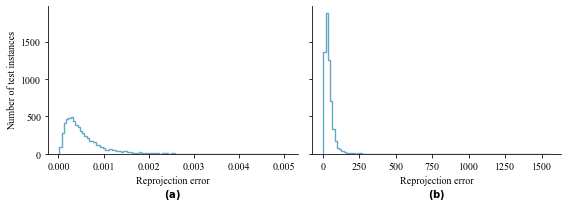

In [8]:
scenar_error_vals_noise, scenar_error_vals_no_noise = [], []

noisy_scenar_ids = (5, 6)
for scenar_id in noisy_scenar_ids:
    scenar_df = scenar_g.get_group(scenar_id)
    error_vals = scenar_df['mean'].values

    if scenar_df[:1]['noise'].bool():
        scenar_error_vals_noise.append(error_vals)
    else:
        scenar_error_vals_no_noise.append(error_vals)

fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharey='all')

x_label = "Reprojection error" + create_subfig_id_label("a")
y_label = "Number of test instances"
plot_error_vals_hist(
    ax_1, scenar_error_vals_no_noise, x_label, y_label
)
x_label = "Reprojection error" + create_subfig_id_label("b")
plot_error_vals_hist(ax_2, scenar_error_vals_noise, x_label)

fig.tight_layout()
fig.savefig("../error_dist_plot_without_and_with_noise.pdf", dpi=300)

In [ ]:
tab_df = scenar_g.head(1).iloc[:, [0] + list(range(2, 8))][
    ['shape', 'n_groups', 'transl', 'rot', 'scale', 'noise']].replace(
    True, 'yes'
).replace(False, 'no')
print(tab_df.to_latex(index=False))

In [ ]:
for scenario_ids_group in scenario_ids_groups:
    for scenar_id in scenario_ids_group:
        scenar_df = scenar_g.get_group(scenar_id)
        improvements = calc_relative_improvements(scenar_df)
        try:
            top_improvements = improvements[:, 5]
            print(f'{scenar_id} --> {np.median(top_improvements)}')
        except:
            pass

In [9]:
from pathlib import Path
from stat_plot import plot_heat_map

data_dir = Path("../../homography_experiments/")
error_grids = np.asarray([
    np.load(str(error_grid_file))
    for error_grid_file in data_dir.iterdir()
    if "error_grid" in error_grid_file.name])
points_groups_orig = np.load(str(data_dir / "points_groups_orig.npy"))

img_shape = config.IMG_HEIGHT, config.IMG_WIDTH

def plot_heatmap_for_marker(
        marker_idx, suffix="", colorbar_range=None, x_label_suffix=""
):
    error_grid = error_grids[marker_idx].reshape(img_shape)

    color = ['gray'] * len(points_groups_orig)
    color[marker_idx] = 'black'

    fig = plot_heat_map(
        error_grid, points_groups_orig, color=color,
        colorbar_range=colorbar_range, x_label_suffix=x_label_suffix
    )
    fig.savefig(
        str(data_dir / f"heat_map_marker_{suffix}.pdf"), dpi=300
    )
    fig.clf()

mean_errors = np.mean(error_grids, axis=1)
baseline = np.mean(mean_errors)
marker_indices = np.argsort(mean_errors)
best_marker_idx, worst_marker_idx = marker_indices[0], marker_indices[-1]
print(best_marker_idx, worst_marker_idx)

min_error = min(
    error_grids[best_marker_idx].min(), error_grids[worst_marker_idx].min()
)
max_error = max(
    error_grids[best_marker_idx].max(), error_grids[worst_marker_idx].max()
)
colorbar_range = (min_error, max_error)

plot_heatmap_for_marker(
    best_marker_idx, "best", colorbar_range, create_subfig_id_label("a")
)
plot_heatmap_for_marker(
    worst_marker_idx, "worst", colorbar_range, create_subfig_id_label("b")
)


FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\homography_experiments\\points_groups_orig.npy'

In [21]:
import os

plot_file_names_map = {
    "improvement_plot_1_2_3_4.pdf": "affine_transform_influence.pdf",
    "improvement_plot_5_6.pdf": "noise_influence.pdf",
    "improvement_plot_6_7_8_9.pdf": "shape_influence.pdf",
    "improvement_plot_10.pdf": "n_markers_3_influence.pdf",
    "improvement_plot_11.pdf": "n_markers_5_influence.pdf",
    "improvement_plot_12.pdf": "n_markers_7_influence.pdf",
    "improvement_plot_13.pdf": "n_markers_9_influence.pdf",
}

dir_path = ".."
for src_name, dst_name in plot_file_names_map.items():
    src_file_path = os.path.join(dir_path, src_name)
    dst_file_path = os.path.join(dir_path, dst_name)
    os.rename(src_file_path, dst_file_path)

FileNotFoundError: [WinError 2] The system cannot find the file specified: '..\\improvement_plot_6_7_8_9.pdf' -> '..\\shape_influence.pdf'

In [55]:
elapsed_times = df[df['time_elapsed_ns'] > 0]['time_elapsed_ns'] / (10 ** 6)
mean_time = np.mean(elapsed_times)
std_dev_time = np.std(elapsed_times)
print(f"Mean execution time: {mean_time:.3f}.")
print(f"Stdev of execution time: {std_dev_time:.3f}.")

Mean execution time: 15.684.
Stdev of execution time: 1.028.


15683866.660308074